In [35]:
import copy
import time
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
from tqdm import tqdm, trange

import loss_landscapes
import loss_landscapes.metrics
import loss_landscapes.model_interface.model_parameters as model_parameters
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
        
batch_size = 256

# download dataset
cifar_train = datasets.CIFAR10(root='/global/cfs/cdirs/m636/geshi/data', train=True, download=True, transform=transform_train)
cifar_test = datasets.CIFAR10(root='/global/cfs/cdirs/m636/geshi/data', train=False, download=True, transform=transform_test)
print(len(cifar_train), len(cifar_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
50000 10000


# Define ResNet

In [3]:
import sys
sys.path.append("/global/u2/g/geshi/PyHessian")

In [4]:
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from models.resnet import resnet
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

In [5]:
# get the model 
model = resnet(num_classes=10,
               depth=20,
               residual_not=True,
               batch_norm_not=True)# change the model to eval mode to disable running stats upate

if torch.cuda.is_available():
    model = model.cuda()
model = torch.nn.DataParallel(model)

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# Load pretrained ResNet

In [7]:
PATH = '/global/u2/g/geshi/PyHessian/checkpoints/net.pkl'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
def test_accuracy(test_loader, net):
    """Evaluate testset accuracy of a model."""
    net.eval()
    acc_sum, count = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # send data to the GPU if cuda is availabel
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            count += inputs.size(0)
            
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            # labels = labels.long()
            acc_sum += torch.sum(preds == labels.data).item()
    return acc_sum/count

In [9]:
since = time.time()
acc = test_accuracy(test_loader, model)
print('time cost ', time.time()-since)
print(acc)

time cost  7.0851263999938965
0.9201


# Loss landscape utils

In [10]:
def eval_warm_up(losslandscaper, data_loader, device, criterion):
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            losslandscaper.warm_up(metric)

In [11]:
def eval_loss(losslandscaper, data_loader, device, criterion):
    count = 0
    loss_data = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = losslandscaper.compute(metric)
            
            loss_data = count/(count+batch_size)*loss_data + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data

In [12]:
def log_refine(loss):
    return np.log(1.+loss)

In [45]:
# contour plot resolution
STEPS = 40
DIST = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_final = copy.deepcopy(model)

# 2D loss landscape

In [16]:
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

In [23]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.random_plane(distance=DIST, normalization='filter', random='normal')
pll.stats_initializer()

In [24]:
# single batch computation
since = time.time()
# pll.warm_up(metric)
loss_data_fin = pll.compute(metric)
print('time cost ', time.time()-since)

time cost  27.536940574645996


In [ ]:
eval_warm_up(pll, train_loader, device, criterion)

In [ ]:
loss_data_fin = eval_loss(pll, train_loader, device, criterion)

In [55]:
loss_data_fin = log_refine(loss_data_fin)

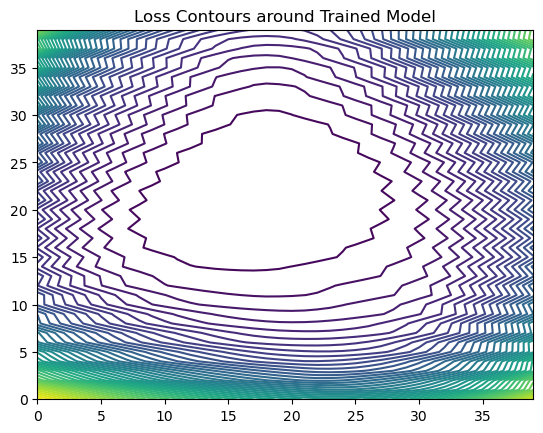

In [25]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

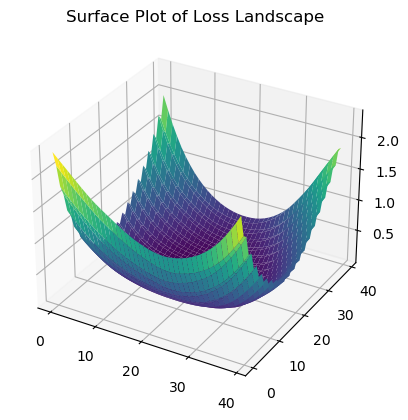

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

# Hessian eigenvector directions

In [28]:
hessian_comp = hessian(model,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       cuda=True)

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [29]:
print(
    '********** finish data londing and begin Hessian computation **********')

top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
trace = hessian_comp.trace()
density_eigen, density_weight = hessian_comp.density()

print('\n***Top Eigenvalues: ', top_eigenvalues)
print('\n***Trace: ', np.mean(trace))

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [386.1632080078125, 269.4181213378906]

***Trace:  1931.870130266462


In [46]:
model_start_wrapper = wrap_model(copy.deepcopy(model))
start_point = model_start_wrapper.get_module_parameters()

model_dir1_wrapper = wrap_model(copy.deepcopy(model))
dir1_point = model_dir1_wrapper.get_module_parameters()

model_dir2_wrapper = wrap_model(copy.deepcopy(model))
dir2_point = model_dir2_wrapper.get_module_parameters()

dir_one = model_parameters.ModelParameters(top_eigenvector[0])
dir_two = model_parameters.ModelParameters(top_eigenvector[1])

dir_one.layer_normalize_(start_point)
dir_two.layer_normalize_(start_point)

# scale to match steps and total distance
dir_one.mul_(((start_point.model_norm() * DIST) / STEPS) / dir_one.model_norm())
dir_two.mul_(((start_point.model_norm() * DIST) / STEPS) / dir_two.model_norm())
# Move start point so that original start params will be in the center of the plot
dir_one.mul_(STEPS / 2)
dir_two.mul_(STEPS / 2)
# Move the start point to dir_end end and dir_two end
start_point.sub_(dir_one)
start_point.sub_(dir_two)
dir1_point.sub_(dir_one)
dir1_point.add_(dir_two)
dir2_point.add_(dir_one)
dir2_point.sub_(dir_two)

In [47]:
### compute random projections and loss
pll = loss_landscapes.PlanarLossLandscape(model_start_wrapper, STEPS, deepcopy_model=True)
pll.interpolation(model_dir1_wrapper, model_dir2_wrapper)
pll.stats_initializer()

In [48]:
# single batch computation
since = time.time()
# pll.warm_up(metric)
loss_data_fin = pll.compute(metric)
print('time cost ', time.time()-since)

time cost  27.641963481903076


In [ ]:
loss_data_fin = log_refine(loss_data_fin)

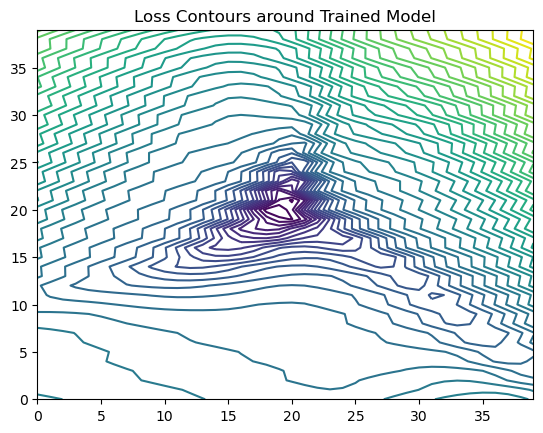

In [56]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

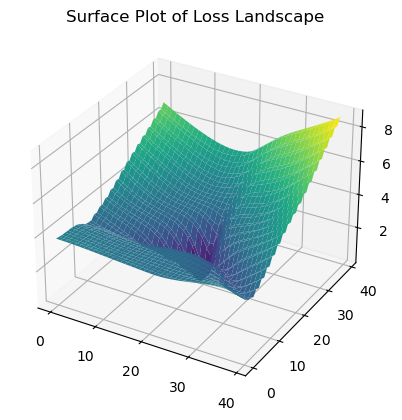

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()